In [431]:
# Imports and plotting preferences
import os
import numpy as np
from sklearn.mixture import GMM
from astropy.io import fits
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

sns.set(style='white', font_scale=1.6, palette='deep')
col = sns.color_palette()

In [66]:
# Class to read, write, and sample from a mixture model.
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def save(model, filename):
        hdus = fits.HDUList()
        hdr = fits.Header()
        hdr['covtype'] = model.covariance_type
        hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
        hdus.append(fits.ImageHDU(model.means_, name='means'))
        hdus.append(fits.ImageHDU(model.covars_, name='covars'))
        hdus.writeto(filename, clobber=True)

    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
        
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X

In [204]:
# Use the Bayesian information criterion to determine how many components we need.
def getbic(X, ncomp=[3]):
    bic = [GMM(n_components=nc, covariance_type="full").fit(X).bic(X) for nc in ncomp]
    #for ii in range(len(ncomp)):
    #    print(ncomp[ii], bic[ii])
    return bic

### Model the [OIII]/Hb, [OII]/Hb, [NII]/Hb, and [SII]/Hb emission-line sequences

In [373]:
# Output file name
forbid_mogfile = os.path.join(os.getenv('DESISIM'), 'data', 'forbidden_mogs.fits')

In [441]:
# Define the valid ranges. MoGs are sensitive to outliers.
oiiihbrange = (-1.5,1.0)
oiihbrange = (-1.2,1.2)
niihbrange = (-2.0,0.8)
siihbrange = (-2.0,0.4)

In [250]:
# Read the catalogs of emission-line objects we will use to calibrate the forbidden emission-line sequences: SDSS 
# (MPA/JHU DR7 catalog); HII region (Moustakas et al. 2010); and integrated spectral atlas data (from 
# Moustakas & Kennicutt 2006).
atlas = fits.getdata(os.path.join(os.getenv('DESI_ROOT'),'data','atlas-emlines.fits.gz'),1)
sdss = fits.getdata(os.path.join(os.getenv('DESI_ROOT'),'data','sdss-emlines.fits.gz'),1)
hii = fits.getdata(os.path.join(os.getenv('DESI_ROOT'),'data','hii-emlines.fits.gz'),1)

atlas = atlas[np.where((atlas['OIIIHB']>oiiihbrange[0])*(atlas['OIIIHB']<oiiihbrange[1])*
                       (atlas['OIIHB']>oiihbrange[0])*(atlas['OIIHB']<oiihbrange[1])*
                       (atlas['NIIHB']>niihbrange[0])*(atlas['NIIHB']<niihbrange[1])*
                       (atlas['SIIHB']>siihbrange[0])*(atlas['SIIHB']<siihbrange[1]))[0]]
sdss = sdss[np.where((sdss['OIIIHB']>oiiihbrange[0])*(sdss['OIIIHB']<oiiihbrange[1])*
                     (sdss['OIIHB']>oiihbrange[0])*(sdss['OIIHB']<oiihbrange[1])*
                     (sdss['NIIHB']>niihbrange[0])*(sdss['NIIHB']<niihbrange[1])*
                     (sdss['SIIHB']>siihbrange[0])*(sdss['SIIHB']<siihbrange[1]))[0]]
hii = hii[np.where((hii['OIIIHB']>oiiihbrange[0])*(hii['OIIIHB']<oiiihbrange[1])*
                   (hii['OIIHB']>oiihbrange[0])*(hii['OIIHB']<oiihbrange[1])*
                   (hii['NIIHB']>niihbrange[0])*(hii['NIIHB']<niihbrange[1])*
                   (hii['SIIHB']>siihbrange[0])*(hii['SIIHB']<siihbrange[1]))[0]]
print('N(atlas)={}, N(HII)={}, N(SDSS)={}'.format(len(atlas), len(hii), len(sdss)))

N(atlas)=188, N(HII)=619, N(SDSS)=93465


In [251]:
# Define some convenience variables.  I decide here to not use the SDSS in the fitting.
#oiiihb = np.concatenate((sdss['OIIIHB'], atlas['OIIIHB'], hii['OIIIHB'])).flatten()
#oiihb  = np.concatenate((sdss['OIIHB'], atlas['OIIHB'], hii['OIIHB'])).flatten()
#niihb  = np.concatenate((sdss['NIIHB'], atlas['NIIHB'], hii['NIIHB'])).flatten()
#siihb  = np.concatenate((sdss['SIIHB'], atlas['SIIHB'], hii['SIIHB'])).flatten()

oiiihb = np.concatenate((atlas['OIIIHB'], hii['OIIIHB'])).flatten()
oiihb  = np.concatenate((atlas['OIIHB'], hii['OIIHB'])).flatten()
niihb  = np.concatenate((atlas['NIIHB'], hii['NIIHB'])).flatten()
siihb  = np.concatenate((atlas['SIIHB'], hii['SIIHB'])).flatten()
Xall = np.array([oiiihb, oiihb, niihb, siihb]).T

print('Total number of objects = {}'.format(len(oiiihb)))

Total number of objects=807


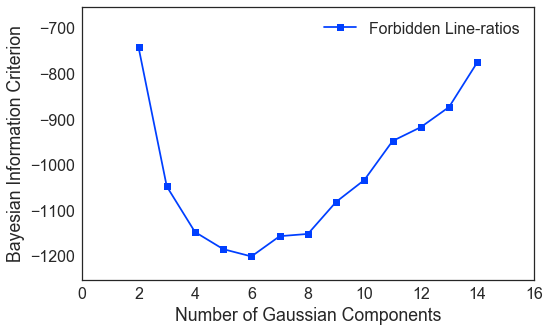

In [429]:
# Determine how many Gaussian components we need by looking at the Bayesian Information Criterion.
ncomp = np.arange(2,15)
bic = getbic(Xall, ncomp)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(ncomp, bic, marker='s', ls='-')
ax.set_xlim((0,16))
ax.set_ylim((-1250,-650))
ax.set_xlabel('Number of Gaussian Components')
ax.set_ylabel('Bayesian Information Criterion')
plt.legend(labels=['Forbidden Line-ratios'])
plt.tight_layout()
plt.show()       

In [374]:
# Model the distribution using a mixture of Gaussians and write out.
ncomp = 6 # from figure above
mog = GMM(n_components=ncomp, covariance_type="full").fit(Xall)
print('Writing {}'.format(forbid_mogfile))
GaussianMixtureModel.save(mog, forbid_mogfile)

Writing /Users/ioannis/repos/git/desihub/desisim/data/forbidden_mogs.fits


In [375]:
# Reread the model.
mog = GaussianMixtureModel.load(forbid_mogfile)
samp = mog.sample(1000)

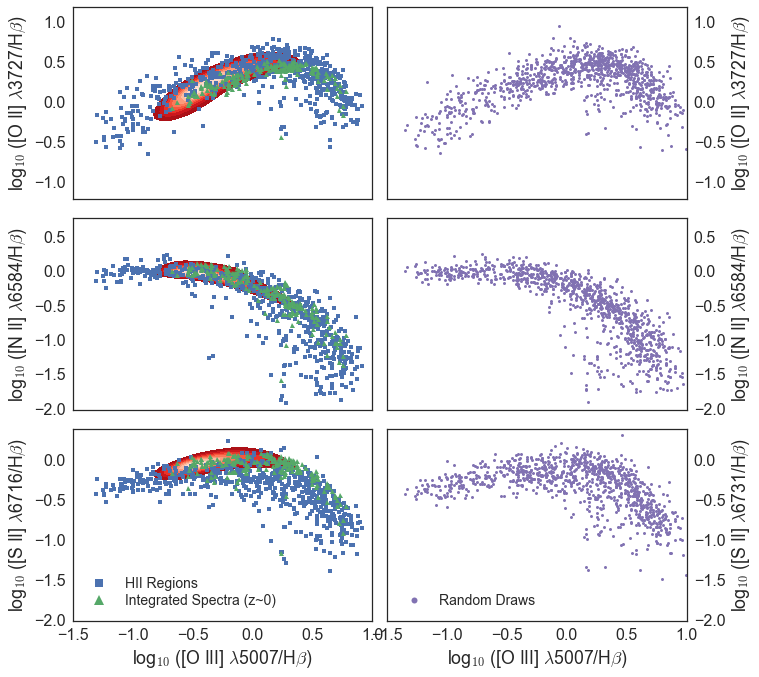

In [461]:
# Now plot the emission-line sequences of interest.  Show the data on the left-hand panels
# and random draws from the MoGs on the right-hand panels.
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(11,11), 
                                                        sharex=True)
                                                    
# [OII]/Hbeta vs [OIII]/Hbeta
ax1.plot(hii['OIIIHB'], hii['OIIHB'], 's', markersize=4, label='HII Regions')
ax1.plot(atlas['OIIIHB'], atlas['OIIHB'], '^', markersize=5, label='Integrated Spectra (z~0)')
sns.kdeplot(sdss['OIIIHB'], sdss['OIIHB'], clip=(xlim, ylim), ax=ax1, gridsize=40,
           cmap="Reds_r", shade=True, cut=0, shade_lowest=False, label='SDSS')
ax1.set_xlim(oiiihbrange)
ax1.set_ylim(oiihbrange)
ax1.set_ylabel(r'log$_{10}$ ([O II] $\lambda$3727/H$\beta$)')

ax2.plot(samp[:,0], samp[:,1], 'o', label='Random Draws', c=col[3], markersize=3)
ax2.set_xlim(oiiihbrange)
ax2.set_ylim(oiihbrange)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'log$_{10}$ ([O II] $\lambda$3727/H$\beta$)')

# [NII]/Hbeta vs [OIII]/Hbeta
ax3.plot(hii['OIIIHB'], hii['NIIHB'], 's', markersize=4, label='HII Regions')
ax3.plot(atlas['OIIIHB'], atlas['NIIHB'], '^', markersize=5, label='Integrated Spectra (z~0)')
sns.kdeplot(sdss['OIIIHB'], sdss['NIIHB'], clip=(xlim, ylim), ax=ax3, gridsize=40,
           cmap="Reds_r", shade=True, cut=0, shade_lowest=False, label='SDSS')
ax3.set_xlim(oiiihbrange)
ax3.set_ylim(niihbrange)
ax3.set_ylabel(r'log$_{10}$ ([N II] $\lambda$6584/H$\beta$)')

ax4.plot(samp[:,0], samp[:,2], 'o', label='Random Draws', c=col[3], markersize=3)
ax4.set_xlim(oiiihbrange)
ax4.set_ylim(niihbrange)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_ylabel(r'log$_{10}$ ([N II] $\lambda$6584/H$\beta$)')

# [SII]/Hbeta vs [OIII]/Hbeta
ax5.plot(hii['OIIIHB'], hii['SIIHB'], 's', markersize=4, label='HII Regions')
ax5.plot(atlas['OIIIHB'], atlas['SIIHB'], '^', markersize=5, label='Integrated Spectra (z~0)')
sns.kdeplot(sdss['OIIIHB'], sdss['SIIHB'], clip=(xlim, ylim), ax=ax5, gridsize=40,
           cmap="Reds_r", shade=True, cut=0, shade_lowest=False, label='SDSS')
ax5.set_xlim(oiiihbrange)
ax5.set_ylim(siihbrange)
ax5.set_ylabel(r'log$_{10}$ ([S II] $\lambda$6716/H$\beta$)')
ax5.set_xlabel(r'log$_{10}$ ([O III] $\lambda$5007/H$\beta$)')
ax5.legend(loc='lower left', prop={'size': 14}, labelspacing=0.25, markerscale=2)

ax6.plot(samp[:,0], samp[:,3], 'o', label='Random Draws', c=col[3], markersize=3)
ax6.set_xlim(oiiihbrange)
ax6.set_ylim(siihbrange)
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax6.set_ylabel(r'log$_{10}$ ([S II] $\lambda$6731/H$\beta$)')
ax6.set_xlabel(r'log$_{10}$ ([O III] $\lambda$5007/H$\beta$)')
ax6.legend(loc='lower left', prop={'size': 14}, labelspacing=0.25, markerscale=2)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()

In [356]:
# Show that the AGES (BGS) sample obeys the same emission-line distributions.
meta = fits.getdata(os.path.join(os.getenv('DESI_BASIS_TEMPLATES'),'bgs_templates_v2.0.fits'),1)

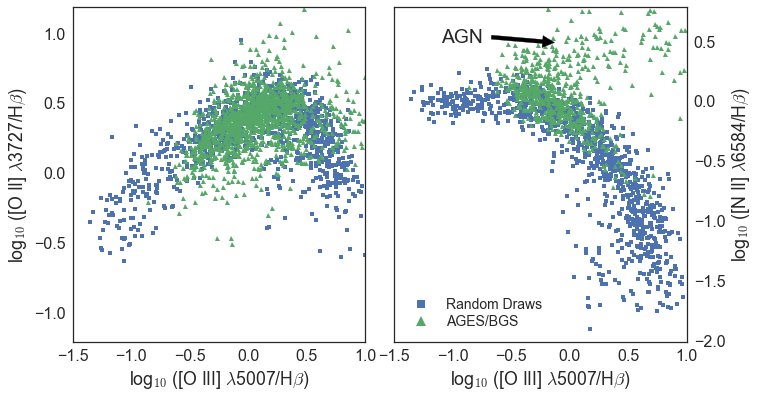

In [462]:
#fig, ax1 = plt.subplots(1, 1, figsize=(8,8))#, sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,6))#, sharey=True)
                                 
# [OII]/Hbeta vs [OIII]/Hbeta
good = np.where((meta['OIIIHBETA']>-900)*(meta['OIIHBETA']>-900)*1)[0]
ax1.plot(samp[:,0], samp[:,1], 's', markersize=4)
ax1.plot(meta['OIIIHBETA'][good], meta['OIIHBETA'][good], '^', markersize=5)
ax1.set_xlim(oiiihbrange)
ax1.set_ylim(oiihbrange)
ax1.set_xlabel(r'log$_{10}$ ([O III] $\lambda$5007/H$\beta$)')
ax1.set_ylabel(r'log$_{10}$ ([O II] $\lambda$3727/H$\beta$)')

# [NII]/Hbeta vs [OIII]/Hbeta
good = np.where((meta['OIIIHBETA']>-900)*(meta['NIIHBETA']>-900)*1)[0]
ax2.plot(samp[:,0], samp[:,2], 's', markersize=4, label='Random Draws')
ax2.plot(meta['OIIIHBETA'][good], meta['NIIHBETA'][good], '^', markersize=5, label='AGES/BGS')
ax2.set_xlim(oiiihbrange)
ax2.set_ylim(niihbrange)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'log$_{10}$ ([N II] $\lambda$6584/H$\beta$)')
ax2.set_xlabel(r'log$_{10}$ ([O III] $\lambda$5007/H$\beta$)')
ax2.legend(loc='lower left', prop={'size': 14}, labelspacing=0.25, markerscale=2)

ax2.annotate('', xy=(-0.1, 0.5), xytext=(-0.7, 0.55),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax2.text(-1.1, 0.5, 'AGN')

fig.subplots_adjust(wspace=0.1)
plt.show()

### Calibrate the EW(H-beta) vs D(4000) sequence for the BGS using the AGES data.

In [466]:
# Output file name
bgs_mogfile = os.path.join(os.getenv('DESISIM'), 'data', 'bgs_mogs.fits')

In [467]:
# Read the BGS metadata.
meta = fits.getdata(os.path.join(os.getenv('DESI_BASIS_TEMPLATES'),'bgs_templates_v2.0.fits'),1)

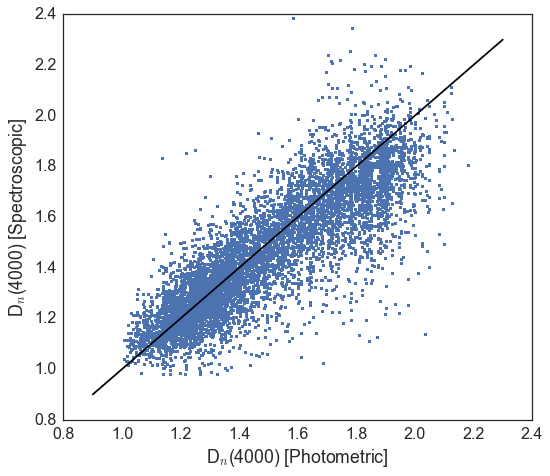

In [468]:
# Show that the photometric and spectroscopic D(4000) values match nicely.
fig, ax = plt.subplots(1, 1, figsize=(8,7))
ax.plot(meta['D4000'], meta['D4000_SPEC'], marker='s', markersize=3, linestyle='None')
ax.plot([0.9,2.3], [0.9,2.3], color='k')
ax.set_xlim((0.8,2.4))
ax.set_ylim((0.8,2.4))
ax.set_xlabel('D$_{n}$(4000) [Photometric]')
ax.set_ylabel('D$_{n}$(4000) [Spectroscopic]')
plt.tight_layout()
plt.show()       

In [484]:
# Separate out galaxies with well-measured H-beta vs upper limits.
good = np.where(meta['HBETA_LIMIT']==0)[0]
limit = np.where(meta['HBETA_LIMIT']==1)[0]
Xages = np.array((meta['D4000'][good], np.log10(meta['HBETA_EW'][good]))).T
Xageslim = np.array((meta['D4000'][limit], np.log10(meta['HBETA_EW'][limit]))).T
print(Xages[:,0].min(), Xages[:,0].max(), Xages[:,1].min(), Xages[:,1].max())

(1.006923, 2.0993757, -0.24361771, 1.9453439)


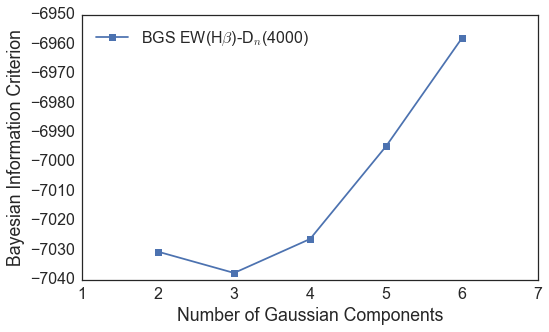

In [481]:
ncomp = np.arange(2,7)
bic = getbic(Xages, ncomp)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(ncomp, bic, marker='s', ls='-')
plt.legend(labels=[r'BGS EW(H$\beta$)-D$_{n}$(4000)'], loc='upper left')
ax.set_xlim((1,ncomp.max()+1))
ax.set_xlabel('Number of Gaussian Components')
ax.set_ylabel('Bayesian Information Criterion')
plt.tight_layout()
plt.show()       

In [486]:
# Model the distribution using a mixture of Gaussians and write out.
ncomp = 3 # from figure above
mog = GMM(n_components=ncomp, covariance_type="full").fit(Xages)
print('Writing {}'.format(bgs_mogfile))
GaussianMixtureModel.save(mog, bgs_mogfile)

Writing /Users/ioannis/repos/git/desihub/desisim/data/bgs_mogs.fits


In [487]:
# Reread the model.
mog = GaussianMixtureModel.load(bgs_mogfile)
samp = mog.sample(1000)

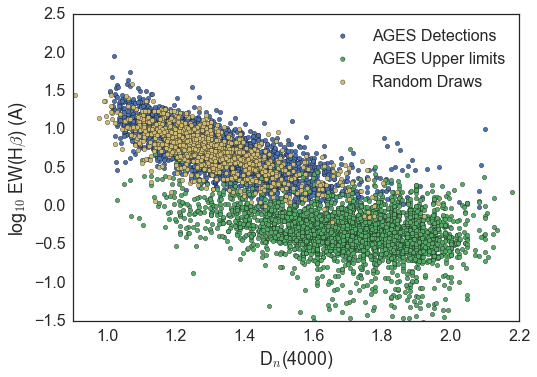

In [489]:
# Make a plot.
plt.scatter(Xages[:,0], Xages[:,1], c=col[0], label='AGES Detections')
plt.scatter(Xageslim[:,0], Xageslim[:,1], c=col[1], label='AGES Upper limits')
plt.scatter(samp[:,0], samp[:,1], c=col[4], label='Random Draws')
plt.xlabel('D$_{n}$(4000)')
plt.ylabel(r'log$_{10}$ EW(H$\beta$) (A)')
plt.xlim((0.9,2.2))
plt.ylim((-1.5,2.5))
plt.legend()
plt.show()

### Calibrate the EW([OII]) vs D(4000) sequence for DEEP2 ELGs.

In [339]:
# Read the ELG metadata as an example.  Focus on D4000 vs EW([OII]).
ff = fits.getdata(os.path.join(os.getenv('DESI_BASIS_TEMPLATES'),'elg_templates_v2.0.fits'),1)
X = np.array((ff['D4000'], np.log10(ff['OII_3727_EW']))).T
print(X)

[[ 1.17296445  1.18387425]
 [ 1.05390465  1.44196427]
 [ 1.07184112  1.93415534]
 ..., 
 [ 1.2665143   1.67456996]
 [ 1.0498594   1.70915151]
 [ 1.0831902   1.34484148]]


In [346]:
# Model the distribution using a mixture of Gaussians (try n=3).  Draw 1000 points.
model = GMM(n_components=3, covariance_type="full").fit(X)
samp = model.sample(1000)

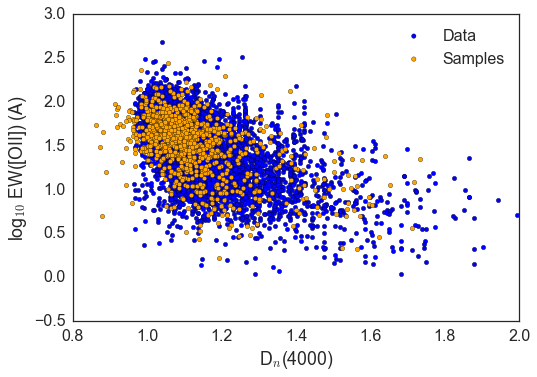

In [347]:
# Make a plot.  Looks pretty good!
plt.scatter(X[:,0],X[:,1],label='Data')
plt.scatter(samp[:,0],samp[:,1],c='orange',label='Samples')
plt.xlabel('D$_{n}$(4000)')
plt.ylabel('log$_{10}$ EW([OII]) (A)')
plt.xlim((0.8,2.0))
plt.legend()
plt.show()

In [9]:
# But how many components should we use? Get the Bayesian information criterion and find the minimum.
ncomp = np.arange(2,11)
bic = np.ndarray(len(ncomp))
for ii, nc in enumerate(ncomp):
    bic[ii] = GMM(n_components=nc, covariance_type="full").fit(X).bic(X)
    print(nc, bic[ii])

(2, -18871.272426283493)
(3, -19554.982092080791)
(4, -19526.763023105301)
(5, -19513.686915646751)
(6, -19606.161048364964)
(7, -19415.226095202863)
(8, -19502.434982943414)
(9, -19457.388795908268)
(10, -19386.43234762807)


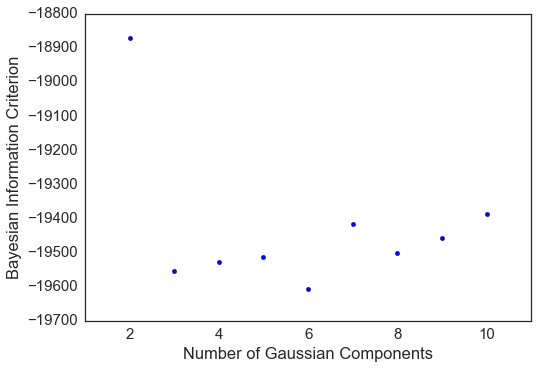

In [10]:
# Make a plot.  Looks like 3 is about right!
plt.scatter(ncomp,bic)
plt.xlabel('Number of Gaussian Components')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [188]:
# But now the question: what's the best way to store the model?!?  Pickle file?  ASCII?

In [ ]:
samp2 = model2.sample(1000)

In [ ]:
plt.scatter(X[:,0],X[:,1],label='Data')
plt.scatter(samp2[:,0],samp2[:,1],c='orange',label='Samples')
plt.xlabel('D(4000)')
plt.ylabel('log$_{10}$ EW([OII]) (A)')
plt.xlim((0.8,2.0))
plt.legend()
plt.show()

In [186]:
X_oiihb = np.array([oiiihb, oiihb]).T
X_niihb = np.array([oiiihb, niihb]).T
X_siihb = np.array([oiiihb, siihb]).T
X = np.array([X_oiihb, X_niihb, X_siihb]).T
#Xall = X.reshape(nobj, 6)
Xall = np.array([oiiihb, oiihb, niihb, siihb]).T
print(X_oiihb.shape, X.shape, Xall.shape)
for thisX in X:
    print(thisX.shape)

((806, 2), (2, 806, 3), (806, 4))
(806, 3)
(806, 3)


(2, 670.74083386666689)
(3, 592.38863895426152)
(4, 507.70173370208573)
(5, 512.72200576115654)
(6, 524.18444093896971)
(7, 534.17215174124806)
(8, 574.74860051820588)
(9, 618.04813496412248)
(10, 646.33628636422577)
(2, 966.6742280415117)
(3, 802.62196433266286)
(4, 785.33675909435783)
(5, 760.78892844595919)
(6, 797.10216496139844)
(7, 829.15908405558912)
(8, 856.9085087440792)
(9, 888.51987079643231)
(10, 922.17001033936629)
(2, 706.75305438953251)
(3, 660.14608914342671)
(4, 620.33485586606571)
(5, 618.33432019782447)
(6, 618.6599621803017)
(7, 646.67951717273559)
(8, 686.9498749142258)
(9, 718.45609784641579)
(10, 748.85083798727089)


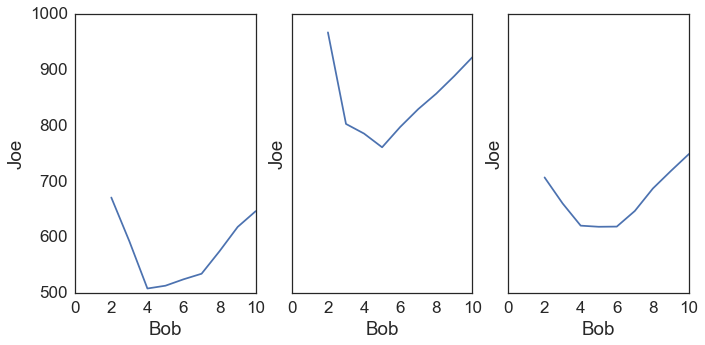

In [162]:
fig, ax = plt.subplots(1, 3, figsize=(11,5), sharey=True)
ncomp = np.arange(2,11)
for ii, thisX in enumerate(X):
    bic = getbic(thisX, ncomp)
    bic.shape, ncomp.shape
    ax[ii].plot(ncomp, bic)
    ax[ii].set_xlim((0,10))
    ax[ii].set_xlabel('Bob')
    ax[ii].set_ylabel('Joe')
plt.show()       